In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
path = "/kaggle/input/masked-gesture-dataset/Masked Gesture Dataset/Masked Gesture Dataset"

In [3]:
IMAGE_SIZE = 128

In [4]:
#convert to grayscale, resize and then normalized between [0, 1]
def image_to_pixel(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0  
    return image

In [5]:
# i have made 2 dicts. one has gesture as key and other has index as key
classes = os.listdir(path) #listing all the labels i.e folder names
gesture_index_dict = {label : index for index, label in enumerate(classes)}
index_gesture_dict = {index : label for index, label in enumerate(classes)}
print(classes)
print(gesture_index_dict)
print(index_gesture_dict)

['1finger', 'thumbsdown', '2finger', '3finger', 'yoyo', 'spreadoutpalm', 'pinky', 'thumbsup', 'fingersclosein', 'kitli', 'italydown']
{'1finger': 0, 'thumbsdown': 1, '2finger': 2, '3finger': 3, 'yoyo': 4, 'spreadoutpalm': 5, 'pinky': 6, 'thumbsup': 7, 'fingersclosein': 8, 'kitli': 9, 'italydown': 10}
{0: '1finger', 1: 'thumbsdown', 2: '2finger', 3: '3finger', 4: 'yoyo', 5: 'spreadoutpalm', 6: 'pinky', 7: 'thumbsup', 8: 'fingersclosein', 9: 'kitli', 10: 'italydown'}


In [6]:
# load the images and labels(indexs)
images = []
labels = []

for label in classes:
    label_path = os.path.join(path, label)
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name)
        images.append(image_to_pixel(image_path))
        labels.append(gesture_index_dict[label])
        
images = np.array(images)
labels = np.array(labels)


In [7]:
# verifying shapes
print(images.shape)
print(labels.shape)


(13462, 128, 128)
(13462,)


In [8]:
# split into train and test sets
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test_split(images, labels, test_size=0.2, random_state=42)
print(X_train_orig.shape)
print(Y_train_orig.shape)

(10769, 128, 128)
(10769,)


In [9]:
X_train = X_train_orig.reshape(X_train_orig.shape[0], -1).T   
X_test = X_test_orig.reshape(X_test_orig.shape[0], -1).T
Y_train = Y_train_orig.reshape(1, Y_train_orig.shape[0])
Y_test = Y_test_orig.reshape(1, Y_test_orig.shape[0])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16384, 10769)
(1, 10769)
(16384, 2693)
(1, 2693)


### plotting some images

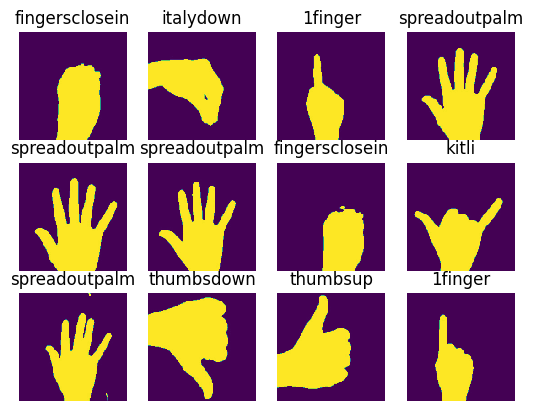

In [10]:
for i in range(0, 12):
    ax = plt.subplot(3, 4, i + 1)
    current_image = X_train[:, i, None].reshape(IMAGE_SIZE, IMAGE_SIZE)
    plt.imshow(current_image, interpolation='nearest')
    label = Y_train[:, i].item()
    plt.title(index_gesture_dict.get(label))
    plt.axis("off")
plt.show()

In [11]:
n_x = X_train.shape[0]  #128 * 128 = 16384 => number of units in input layer
n_h = 200   #number of units in hidden layer
n_y = 11    #number of units in output layer
print(n_x)

16384


### activation functions and its derivative

In [12]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def ReLU_deriv(Z):
    return Z > 0

def compute_cost(A2, Y):
    m = Y.size
    cost = -1/m * np.sum(Y*np.log(A2))
    return cost

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [13]:
# INITIALIZATION

def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1)) 
    return W1, b1, W2, b2

def forward_prop(W1, b1, W2, b2, X):
    Z1 =  W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1)  + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha = 0.2):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [14]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

In [15]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = initialize_parameters(n_x, n_h, n_y)
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        cost = compute_cost(A2, one_hot(Y))
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0 or i == iterations - 1:
            print("Iteration: ", i)
            print(f"cost after iteration  {i} : {np.squeeze(cost)}")
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"accuracy after iteration {i} : {accuracy * 100:.2f} % "  )
    return W1, b1, W2, b2

### Training the model

In [16]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 250)

Iteration:  0
cost after iteration  0 : 0.21842032206276207
[2 4 3 ... 2 2 2] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 0 : 9.31 % 
Iteration:  50
cost after iteration  50 : 0.049533585377895574
[ 8 10  0 ...  2  0  5] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 50 : 87.62 % 
Iteration:  100
cost after iteration  100 : 0.02049359077204544
[ 8 10  0 ...  4  0  5] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 100 : 94.41 % 
Iteration:  150
cost after iteration  150 : 0.009406626427499117
[ 8 10  0 ...  4  0  5] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 150 : 98.11 % 
Iteration:  200
cost after iteration  200 : 0.006115378199355073
[ 8 10  0 ...  4  0  5] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 200 : 98.98 % 
Iteration:  249
cost after iteration  249 : 0.004366858924213598
[ 8 10  0 ...  4  0  5] [[ 8 10  0 ...  4  0  5]]
accuracy after iteration 249 : 99.39 % 


In [17]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    predicted_label = (make_predictions(X_train[:, index, None], W1, b1, W2, b2)).item()
    correct_label = (Y_train[:,index]).item()
    print("Prediction: ", index_gesture_dict.get(predicted_label))
    print("correct Label: ", index_gesture_dict.get(correct_label))
    
    current_image = current_image.reshape((128, 128)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  thumbsup
correct Label:  thumbsup


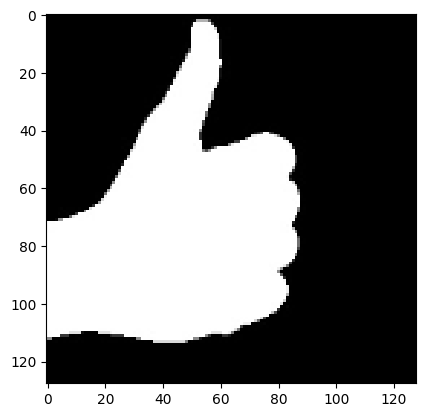

In [18]:
test_prediction(10, W1, b1, W2, b2)

### Testing the trained model

In [19]:
test_prediction = make_predictions(X_test, W1, b1, W2, b2)
test_accuracy = get_accuracy(test_prediction, Y_test)
print(f"test accuracy : {test_accuracy * 100 : .2f}%")

[0 4 6 ... 8 2 9] [[0 4 6 ... 8 2 9]]
test accuracy :  98.33%
